In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
TRAIN_DIR = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\data\\prepared-data\\train"  
VAL_DIR = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\data\\prepared-data\\val"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8 # Kvasir-v2 için 8 sınıf var
EPOCHS = 20 # Denemeler için 20, sonrasında artırılabilir
MODEL_SAVE_PATH = "C:\\Users\\ofaru\\Desktop\\GitHub\\Gastroenterology-CNN-Comparison\\models\\" # Modellerin kaydedileceği yer

# Klasörün var olduğundan emin ol
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [3]:
# 'categorical' kullanıyoruz çünkü 8 sınıfımız var
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_dataset.class_names
print("Sınıflar:", class_names)

# Performans için veri setlerini önbelleğe al
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 5592 files belonging to 8 classes.
Found 1600 files belonging to 8 classes.
Sınıflar: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


In [4]:
def get_base_model():
    return applications.MobileNetV3Small(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')

def get_preprocessing_pipeline():
    return models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),
        # Adım 1: Grayscale'e çevir (1 kanal) ve geri RGB'ye (3 kanal) dönüştür
        layers.Lambda(lambda x: tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(x))),
        # Adım 2: Augmentation uygula
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        # Adım 3: Ölçeklendir
        layers.Rescaling(1./255)
    ], name="aug_gray_pipeline")
experiment_name = "mobilenetv3_augmented_grayscale"


In [5]:
def create_model(base_model_func, preprocessing_pipeline_func, num_classes):
    # Transfer Learning için temel modeli al ve dondur
    base_model = base_model_func()
    base_model.trainable = False
    
    # Ön işleme hattını al
    preprocessing_pipeline = preprocessing_pipeline_func()
    
    # Modeli birleştir
    inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
    x = preprocessing_pipeline(inputs)
    x = base_model(x, training=False) # 'training=False' önemlidir
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

print(f"Deney Başlatılıyor: {experiment_name}")
model = create_model(get_base_model, get_preprocessing_pipeline, NUM_CLASSES)
model.summary()

Deney Başlatılıyor: mobilenetv3_augmented_grayscale



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_gray_pipeline (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         4,616 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 943,736 (3.60 MB)

 Trainable params: 4,616 (18.03 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [6]:
start_time = time.time()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)
end_time = time.time()
print(f"Eğitim Süresi: {end_time - start_time:.2f} saniye")

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.1252 - loss: 2.1264 - val_accuracy: 0.1256 - val_loss: 2.0737
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.1350 - loss: 2.1053 - val_accuracy: 0.1319 - val_loss: 2.0648
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.1391 - loss: 2.0863 - val_accuracy: 0.1488 - val_loss: 2.0553
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.1372 - loss: 2.0838 - val_accuracy: 0.1856 - val_loss: 2.0468
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.1418 - loss: 2.0788 - val_accuracy: 0.1856 - val_loss: 2.0396
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.1529 - loss: 2.0707 - val_accuracy: 0.1956 - val_loss: 2.0311
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.1622 - loss: 2.0627 - val_accuracy: 0.2037 - val_loss: 2.0244
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.1704 - loss: 2.0570 - 

In [7]:
model_filename = os.path.join(MODEL_SAVE_PATH, f"{experiment_name}.h5")
model.save(model_filename)
print(f"Model başarıyla kaydedildi: {model_filename}")

Model başarıyla kaydedildi: C:\Users\ofaru\Desktop\GitHub\Gastroenterology-CNN-Comparison\models\mobilenetv3_augmented_grayscale.h5


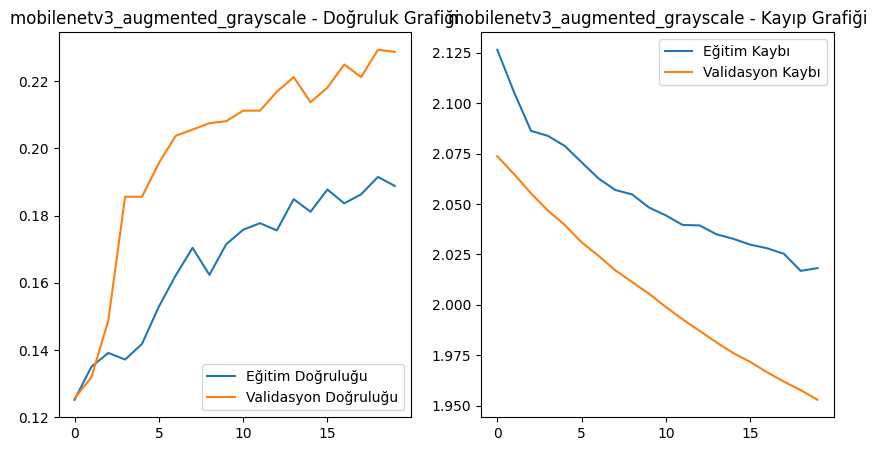

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Validasyon Doğruluğu')
plt.legend(loc='lower right')
plt.title(f'{experiment_name} - Doğruluk Grafiği')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Validasyon Kaybı')
plt.legend(loc='upper right')
plt.title(f'{experiment_name} - Kayıp Grafiği')
plt.show()